# Introduction


In the project this week, we will focus on model performance monitoring for the news classification model that we deployed in week 3 (and developed in weeks 1 and 2)

1. We will download and parse the training dataset, logs from prediction service that record inference traffic and annotations (ground truth labels for the inference traffic)
2. We will set up basic monitoring for system health (traffic volume, latency, SLA violations)
3. We will compute data and label drift for the inference traffic using a few different techniques (Chi-square statistic, KS-statistic, classifier-based drift detection)
4. We will understand model performance as a function of time for the inference traffic, and any ties we can derive to detected drift
5. [optional] We will experiment with outlier detection techniques and understand the impact of outliers on model performance.



## Step1: Prereqs & Installation

Download & Import all the necessary libraries we need throughout the project.

In [1]:
# Install all the required dependencies for the project

!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install umap-learn
!pip install plotly
!pip install alibi-detect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=61572b06b7cc65baa989e3f7e3f0973f6e5d8495dfa733121474075b39515a8b
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=381f372468234c17800bfc40ea031c25f85e73309f5ca524d112edab1d1e2fff
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
import json
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import umap
from sklearn import metrics as sklearn_metrics
import seaborn as sns


In [3]:
# Global Constants

LABEL_SET = [
    'Business',
    'Sci/Tech',
    'Software and Developement',
    'Entertainment',
    'Sports',
    'Health',
    'Toons',
    'Music Feeds'
]

DATA_URL = 'https://corise-mlops.s3.us-west-2.amazonaws.com/project4/agnews_logs.zip'

LOG_DATE_START = date(2022, 7, 11)   # '2022-07-11'
LOG_DATE_END = date(2022, 7, 24)   # '2022-07-24'

## Step 2: Download and Load Dataset

In weeks 1 and 2, we worked with a modified version of the [AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) dataset - a collection of more than 1 million news articles gathered from more than 2000 news sources by an academic news search engine. This news topic classification dataset & benchmark was first used in [Character-level Convolutional Networks for Text Classification (NIPS 2015)](https://arxiv.org/abs/1509.01626).

In week 3, we started logging model inputs and predictions for the web application that we created for the trained news classifier.

The dataset for this week's project is a combination of the two. We will work with the following files in the downloaded data:
1. `training.json` -- this is the training data on which the classification model was trained. This will act as the reference dataset when we want to compute things like drift and outliers. Each row in this file is a training data point.
2. `logs.json` -  this is a collection of logged outputs from our online service (the inference traffic). Each row in this file is a timestamped request, and contains the input request (text description, embedding, url etc) as well as model predictions. This will act as the target dataset when we want to compute things like drift and outliers. **The logs span a two week period from 2022/07/11 to 2022/07/24.**
3. `annotations.json` - this is the set of ground truth labels for requests received by our online prediction service. Imagine we have a team of human annotators that label a fraction of our inference stream (with some delay). Eventually these ground truth labels are logged and will be helpful for us to monitor online model performance, and also is a good source of future training data for the model.

Sample row in the training dataset:
```
{
   "id": 86273,
   "source": "Voice of America",
   "title": "Capsule from Genesis Space Probe Crashes in Utah Desert",
   "url": "http://www.sciencedaily.com/releases/2004/09/040908090621.htm",
   "rank": "5",
   "description": "A capsule carrying solar material from the Genesis space probe has made a crash landing at a US Air Force training facility in the US state of Utah.",
   "embedding": [...],
   "label": "Sci/Tech"
}
```

Sample row in the logs file:

```
{
    "id": 69265,
    "timestamp": "2022-07-11 00:00:00",
    "host_id": "host_4",
    "latency_ms": 169.676,
    "request": {
        "id": 69265,
        "source": null,
        "title": "Google May Face Another Lawsuit",
        "url": "http://www.pcworld.com/news/article/0,aid,117686,00.asp",
        "rank": "5",
        "description": "A federal judge in Virginia has ruled that a trademark infringement suit filed by the Government Employees Insurance Co. (GEICO) against Internet search giants Google and Overture Services can proceed.",
        "embedding": [...]
    },
    "pred_label": "Business",
    "pred_score": {
        "Business": 0.39581484916169474,
        "Entertainment": 0.19195937955028541,
        "Health": 0.02007952252798203,
        "Music Feeds": 0.0005983183076385058,
        "Sci/Tech": 0.3849374113779283,
        "Software and Developement": 0.001389120851963045,
        "Sports": 0.004566606342231832,
        "Toons": 0.0006547918802761208
    }
}
```
Sample row in the annotations file (rows in here should be joined to the correct request in `logs.json` using the "id" field):
```
{
    "id": 69265,
    "label": "Sci/Tech"
}
```

In [4]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

DIRECTORY_NAME = "data"


def download_dataset():
    """
    Download the dataset. The zip contains three files: train.json, test.json and unlabeled.json
    """
    http_response = urlopen(DATA_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DIRECTORY_NAME)


# Expensive operation so we should just do this once
download_dataset()


In [5]:
"""
[TO BE IMPLEMENTED]

1. Load the training dataset, inference logs and annotations from the downloaded data
2. Join the rows from `logs.json` and `annotations.json`.
   Rows in these files should be matched using the "id" field - this is unique string assigned to each incoming request
"""

def load_json_file(_path):
    data = []
    with open(_path) as _file:
        for line in _file:
            data.append(json.loads(line))

    return data

training = load_json_file('data/training.json')

# The logs span a two week period from 2022/07/11 to 2022/07/24.
logs = load_json_file('data/logs.json')

true_labels = load_json_file('data/annotations.json')


Join logs and annotations by id.

In [6]:
combined_data = []
indexed_annotations = {annot['id']: annot for annot in true_labels}
for entry in logs:
    entry.update(indexed_annotations[entry['id']])
    combined_data.append(entry)

**Sanity Check**

## Step 3: System Health & Metrics

As we saw in the lecture, software system failures and downtimes are remarkably common even in ML systems. In an [analysis](https://www.youtube.com/watch?v=hBMHohkRgAA) conducted by Daniel Papasian and Todd Underwood (both ML engineers at Google), they looked at large ML pipeline failures at Google and found out that in 60 out of the 96 cases, the cause for failure was not directly related to the ML model.

For such cases, tracking system health can be a good first step to ensure properties such as whether the deployed model is available online, is its latency within acceptable SLAs, are the system resources (such as CPU and memory usage) within bounds etc.


In [7]:
"""
[TO BE IMPLEMENTED]

Each row in the logs.json file has an associated timestamp of the format YYYY-MM-DD HH:MM:SS.
The logs span a two week period from 2022/07/11 to 2022/07/24.
We will use the timestamp to group requests by date, and track a few system metrics of interest:

1. Volume: Compute the daily volume of requests received by our service, grouped by host id.
2. Latency: Compute the mean, median, P90, P95 latency of requests received by our service, grouped by host id
3. Plot each of these as a line chart, with date on the X-axis and the computed metric on the Y-axis.
You can plot the metric for each host id in the same line chart (with different colors for each host).

Do you notice anything strange with one of the hosts? :)

"""


'\n[TO BE IMPLEMENTED]\n\nEach row in the logs.json file has an associated timestamp of the format YYYY-MM-DD HH:MM:SS.\nThe logs span a two week period from 2022/07/11 to 2022/07/24.\nWe will use the timestamp to group requests by date, and track a few system metrics of interest:\n\n1. Volume: Compute the daily volume of requests received by our service, grouped by host id.\n2. Latency: Compute the mean, median, P90, P95 latency of requests received by our service, grouped by host id\n3. Plot each of these as a line chart, with date on the X-axis and the computed metric on the Y-axis.\nYou can plot the metric for each host id in the same line chart (with different colors for each host).\n\nDo you notice anything strange with one of the hosts? :)\n\n'

Add date only column to combined request logs and true_label dataframe and clean up the dataframe.

In [8]:
combined_data_df = pd.DataFrame(combined_data)
combined_data_df.set_index('id', inplace=True)
combined_data_df['date'] = pd.to_datetime(combined_data_df['timestamp']).dt.date
combined_data_df

,timestamp,host_id,latency_ms,request,pred_label,pred_score,label,date
id,,,,,,,,
69265,2022-07-11 00:00:00,host_4,169.676,"{'id': 69265, 'source': None, 'title': 'Google...",Business,"{'Business': 0.39581484916169474, 'Entertainme...",Sci/Tech,2022-07-11
444122,2022-07-11 00:00:09,host_3,183.468,"{'id': 444122, 'source': 'Reuters', 'title': '...",Health,"{'Business': 0.03158270082143275, 'Entertainme...",Health,2022-07-11
330629,2022-07-11 00:00:17,host_1,176.948,"{'id': 330629, 'source': None, 'title': 'All-S...",Sports,"{'Business': 0.004083249952881476, 'Entertainm...",Sports,2022-07-11
95664,2022-07-11 00:00:26,host_2,123.724,"{'id': 95664, 'source': 'Channel News Asia', '...",Entertainment,"{'Business': 0.011457933535418576, 'Entertainm...",Health,2022-07-11
482461,2022-07-11 00:01:09,host_3,149.040,"{'id': 482461, 'source': None, 'title': 'Euron...",Business,"{'Business': 0.7837987635037846, 'Entertainmen...",Business,2022-07-11
...,...,...,...,...,...,...,...,...
id_170212,2022-07-24 23:57:52,host_4,159.628,"{'id': 170212, 'source': None, 'title': 'SOUND...",Business,"{'Business': 0.29256321183473, 'Entertainment'...",Entertainment,2022-07-24
id_150175,2022-07-24 23:58:07,host_1,170.576,"{'id': 150175, 'source': 'Yahoo Tech', 'title'...",Entertainment,"{'Business': 0.2749596455915785, 'Entertainmen...",Sci/Tech,2022-07-24
id_221782,2022-07-24 23:58:18,host_5,256.864,"{'id': 221782, 'source': None, 'title': 'Slow ...",Business,"{'Business': 0.7640256842424966, 'Entertainmen...",Entertainment,2022-07-24


**Group combined inference request data by host_ids and date**

In [9]:
combined_groups = combined_data_df.groupby(['host_id', 'date'])

### Daily Request Volume by Grouped Hosts

In [10]:
combined_groups['latency_ms'].agg('count').unstack('host_id')

host_id,host_1,host_2,host_3,host_4,host_5
date,,,,,
2022-07-11,1529.0,1462.0,1574.0,1435.0,NaN
2022-07-12,1496.0,1500.0,1500.0,1504.0,NaN
2022-07-13,1508.0,1508.0,1470.0,1514.0,NaN
2022-07-14,1502.0,1462.0,1549.0,1487.0,NaN
2022-07-15,1504.0,1453.0,1540.0,1503.0,NaN
2022-07-16,1571.0,1452.0,1489.0,1488.0,NaN
2022-07-17,1502.0,1521.0,1480.0,1497.0,NaN
2022-07-18,1323.0,1304.0,1297.0,1277.0,1299.0
2022-07-19,1272.0,1277.0,1344.0,1271.0,1336.0


<Axes: title={'center': 'Daily Request Volume Grouped By Hosts'}, xlabel='date', ylabel='Daily Request Volume'>

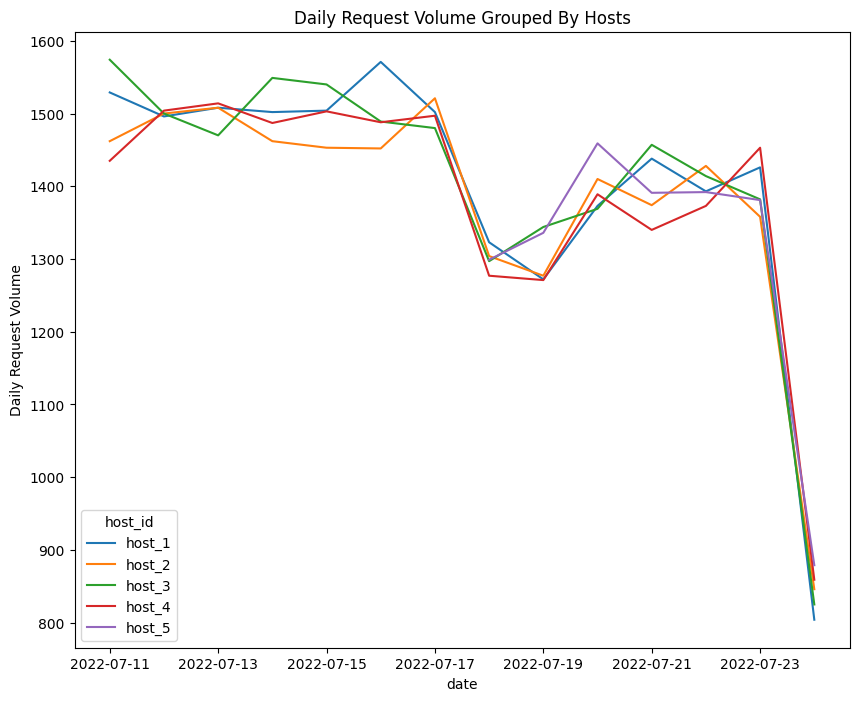

In [11]:
combined_groups['latency_ms'].agg('count').unstack('host_id').plot(figsize=(10, 8), ylabel='Daily Request Volume', title='Daily Request Volume Grouped By Hosts')

### Average Daily Latency by Grouped Hosts

In [12]:
combined_groups.agg('mean').unstack('host_id')

<ipython-input-12-fc8e4a3e382e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  combined_groups.agg('mean').unstack('host_id')


latency_ms                                                
host_id         host_1      host_2      host_3      host_4      host_5
date                                                                  
2022-07-11  181.131550  179.710979  180.155809  180.486632         NaN
2022-07-12  180.478495  179.876317  180.409369  179.582791         NaN
2022-07-13  179.025078  179.737743  180.037602  179.386606         NaN
2022-07-14  181.051389  180.176701  181.351465  179.332506         NaN
2022-07-15  178.786841  179.955186  179.884221  181.395121         NaN
2022-07-16  179.517573  179.740993  180.160132  179.940056         NaN
2022-07-17  179.511174  180.176291  179.904651  179.285883         NaN
2022-07-18  180.081005  179.316137  180.082561  179.512242  250.276309
2022-07-19  180.335466  179.507352  178.990328  180.143841  249.908109
2022-07-20  180.727063  180.600167  181.200947  179.625061  250.784256
2022-07-21  179.557197  180.774445  180.060346  180.416659  249.173102
2022-07-22  181.296365  179.706855  179.396436  179.988413  250.451626
2022-07-23  179.341982  180.471367  179.588671  180.370118  250.335080
2022-07-24  179.319215  180.896988  179.320998  181.524916  249.522986

<ipython-input-13-857fa42beb27>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  combined_groups.agg('mean').unstack('host_id').plot(figsize=(10, 8), ylabel='Mean Latency', title='Mean Latency (ms) Grouped by Hosts')


<Axes: title={'center': 'Mean Latency (ms) Grouped by Hosts'}, xlabel='date', ylabel='Mean Latency'>

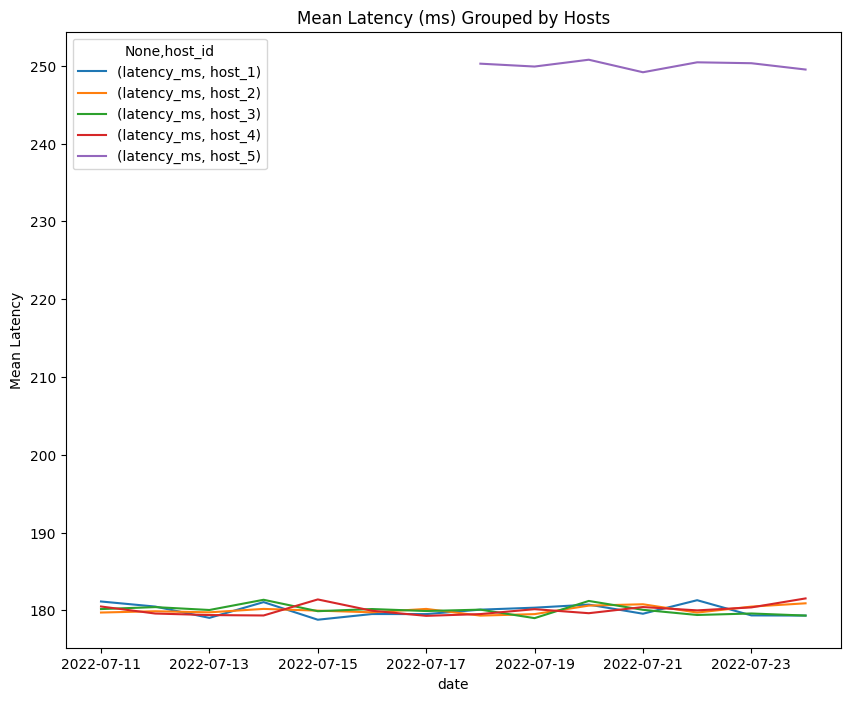

In [13]:
combined_groups.agg('mean').unstack('host_id').plot(figsize=(10, 8), ylabel='Mean Latency', title='Mean Latency (ms) Grouped by Hosts')

### 50th, 90th, 95th Percentile of Daily Latency Grouped by Hosts

In [14]:
#create functions to calculate 50th, 90th and 95th quartiles
def P50(x):
    return x.quantile(0.50)

def P90(x):
    return x.quantile(0.90)

def P95(x):
    return x.quantile(0.95)

**50th Percentile of Daily Latency Grouped by Hosts**

In [15]:
combined_groups.agg('median').unstack('host_id')

<ipython-input-15-5122dc361f02>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  combined_groups.agg('median').unstack('host_id')


latency_ms                                        
host_id        host_1    host_2    host_3    host_4    host_5
date                                                         
2022-07-11   181.1080  179.7075  180.0170  180.6530       NaN
2022-07-12   181.0520  179.9345  180.2665  179.2950       NaN
2022-07-13   179.4660  179.6685  180.6200  178.6330       NaN
2022-07-14   182.0915  180.6690  181.6030  179.3280       NaN
2022-07-15   178.3585  180.5830  180.9080  182.1300       NaN
2022-07-16   179.4490  179.5780  180.0250  180.2285       NaN
2022-07-17   179.2255  180.0840  179.6040  179.3910       NaN
2022-07-18   180.7320  180.5990  180.1350  180.3670  250.2930
2022-07-19   181.1960  179.6240  179.7215  179.3910  249.3285
2022-07-20   181.1630  180.6300  181.1150  179.2620  250.2760
2022-07-21   178.9255  181.3960  180.6030  180.8095  248.6210
2022-07-22   181.6320  179.7400  179.8570  180.0960  249.4175
2022-07-23   179.8955  181.1040  180.4010  179.7530  249.9900
2022-07-24   179.7045  182.0470  179.9480  182.7770  250.1340

<ipython-input-16-6a86a56f585b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  combined_groups.agg('median').unstack('host_id').plot(figsize=(10, 8), ylabel='Median Latency', title='Median Latency (ms) Grouped by Hosts')


<Axes: title={'center': 'Median Latency (ms) Grouped by Hosts'}, xlabel='date', ylabel='Median Latency'>

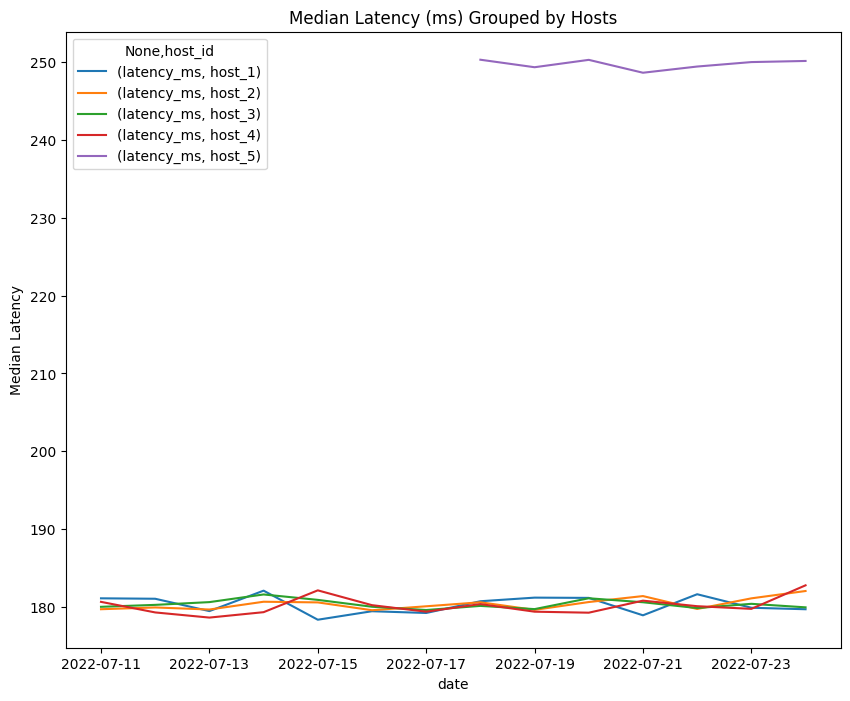

In [16]:
combined_groups.agg('median').unstack('host_id').plot(figsize=(10, 8), ylabel='Median Latency', title='Median Latency (ms) Grouped by Hosts')

90th Percentile of Daily Latency Grouped by Hosts

In [17]:
combined_groups.agg(P90).unstack('host_id')

<ipython-input-17-e6698ab338d1>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P90).unstack('host_id')
<ipython-input-17-e6698ab338d1>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P90).unstack('host_id')
<ipython-input-17-e6698ab338d1>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P90).unstack('host_id')
<ipython-input-17-e6698ab338d1>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future vers

latency_ms                                        
host_id        host_1    host_2    host_3    host_4    host_5
date                                                         
2022-07-11   211.9874  211.6533  212.6383  213.3316       NaN
2022-07-12   210.5155  210.9136  212.6962  210.4239       NaN
2022-07-13   211.8113  212.6210  211.4756  211.8929       NaN
2022-07-14   214.1207  211.8139  212.9054  211.7258       NaN
2022-07-15   212.9058  211.9164  211.9541  212.4290       NaN
2022-07-16   213.4310  211.2759  211.2856  211.9945       NaN
2022-07-17   210.7991  211.6140  210.8715  210.0900       NaN
2022-07-18   211.5758  212.8387  212.0836  211.0722  288.5280
2022-07-19   212.0461  212.0946  209.9012  212.4530  286.9780
2022-07-20   212.9662  212.1199  212.4160  212.4326  290.4314
2022-07-21   211.3243  211.2547  212.5472  212.0049  287.0410
2022-07-22   214.3878  212.6382  211.3684  210.8618  289.2219
2022-07-23   210.5490  212.3808  211.6028  214.1014  289.6630
2022-07-24   210.5830  211.2455  210.3818  212.2852  287.2256

<ipython-input-18-7b3ae3b63c49>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P90).unstack('host_id').plot(figsize=(10, 8), ylabel='90th Percentile Latency', title='90th Percentile Latency (ms) Grouped by Hosts')
<ipython-input-18-7b3ae3b63c49>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P90).unstack('host_id').plot(figsize=(10, 8), ylabel='90th Percentile Latency', title='90th Percentile Latency (ms) Grouped by Hosts')
<ipython-input-18-7b3ae3b63c49>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only co

<Axes: title={'center': '90th Percentile Latency (ms) Grouped by Hosts'}, xlabel='date', ylabel='90th Percentile Latency'>

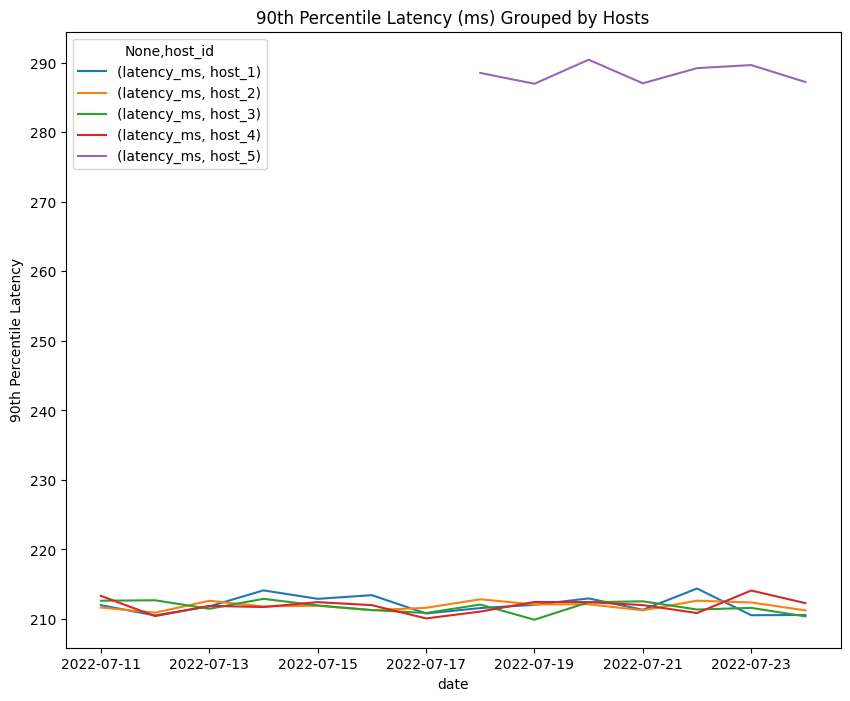

In [18]:
combined_groups.agg(P90).unstack('host_id').plot(figsize=(10, 8), ylabel='90th Percentile Latency', title='90th Percentile Latency (ms) Grouped by Hosts')

95th Percentile of Daily Latency Grouped by Hosts

In [19]:
combined_groups.agg(P95).unstack('host_id')

<ipython-input-19-51d671459f81>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P95).unstack('host_id')
<ipython-input-19-51d671459f81>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P95).unstack('host_id')
<ipython-input-19-51d671459f81>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P95).unstack('host_id')
<ipython-input-19-51d671459f81>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future vers

latency_ms                                            
host_id        host_1     host_2     host_3     host_4     host_5
date                                                             
2022-07-11  219.91820  221.09695  221.82030  222.47790        NaN
2022-07-12  218.62175  219.64335  222.00405  218.82955        NaN
2022-07-13  219.78460  220.29425  220.53860  221.58490        NaN
2022-07-14  223.21855  219.86510  220.22460  220.97930        NaN
2022-07-15  221.22150  221.10100  219.99700  220.79240        NaN
2022-07-16  223.40650  221.06800  219.57540  220.00855        NaN
2022-07-17  221.09460  221.74600  219.36170  219.47680        NaN
2022-07-18  221.21490  220.25280  220.54580  219.86340  300.93830
2022-07-19  219.80755  220.59200  219.59850  221.65700  299.09300
2022-07-20  222.25820  222.54300  221.78560  222.68680  302.16970
2022-07-21  221.60310  219.64090  220.64280  221.26040  297.87000
2022-07-22  222.70740  221.56240  221.78320  219.74000  302.35765
2022-07-23  220.04500  221.13165  221.04965  223.94260  302.71000
2022-07-24  221.86440  219.27850  222.26120  221.27480  300.46430

<ipython-input-20-d523d745f4e7>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P95).unstack('host_id').plot(figsize=(10, 8), ylabel='95th Percentile Latency', title='95th Percentile Latency (ms) Grouped by Hosts')
<ipython-input-20-d523d745f4e7>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  combined_groups.agg(P95).unstack('host_id').plot(figsize=(10, 8), ylabel='95th Percentile Latency', title='95th Percentile Latency (ms) Grouped by Hosts')
<ipython-input-20-d523d745f4e7>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only co

<Axes: title={'center': '95th Percentile Latency (ms) Grouped by Hosts'}, xlabel='date', ylabel='95th Percentile Latency'>

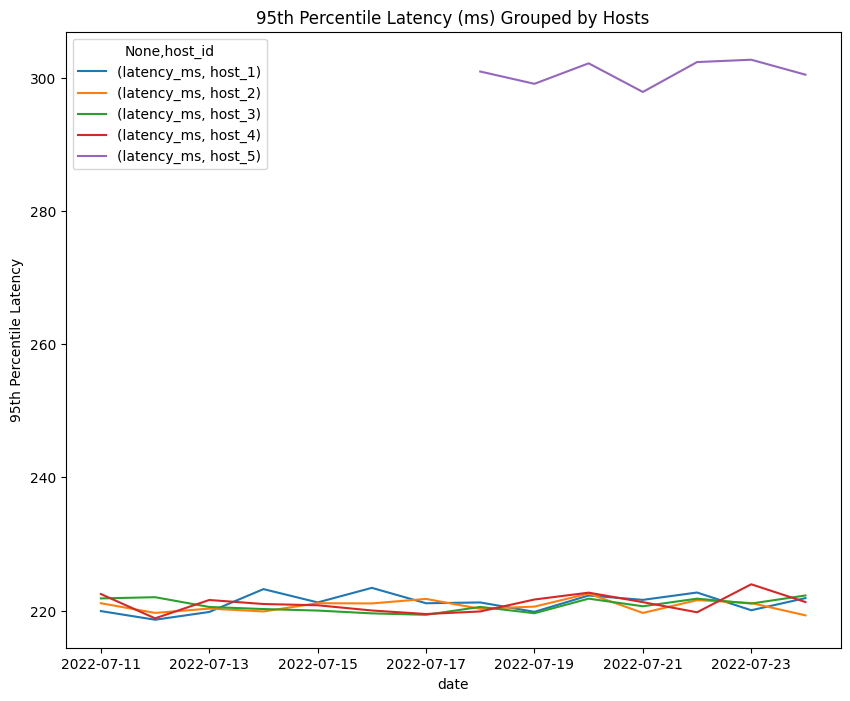

In [20]:
combined_groups.agg(P95).unstack('host_id').plot(figsize=(10, 8), ylabel='95th Percentile Latency', title='95th Percentile Latency (ms) Grouped by Hosts')

#### To be Deleted

In [21]:
# combined_data_df.groupby(['host_id', 'date'])['host_id'].count()

In [22]:
# combined_groups.agg(['mean', 'count', 'median'])

In [23]:
# combined_groups.describe()

In [24]:
# combined_groups.median()

In [25]:
# combined_groups.quantile(q=0.90)

In [26]:
# combined_groups.agg(['mean', 'count', 'median']).plot()

In [27]:
# combined_groups.size().to_frame()

In [28]:
# combined_aggregates['host_id']#.plot()
# combined_groups['host_id']#.plot(legend=True)

In [29]:
# combined_aggregates['host_id']#.plot()

In [30]:
# combined_aggregates.unstack('host_id')

In [31]:
# combined_aggregates.unstack('host_id').plot(figsize=(20, 10))
#.loc[:, 'latency_ms'].plot()

### Daily Volume of Latency SLA Violations Grouped by Hosts

In [32]:
"""
[TO BE IMPLEMENTED]

Let us say that we have a maximum latency SLA of 300 milliseconds i.e.
if the prediction service took more than 300 ms to answer the request, the downstream experience is degraded for users.

1. Compute the aggregate daily volume of latency SLA violations (i.e. number of requests that have a latency >= maximum allowed latency) grouped by each host id
2. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.
"""

combined_groups['latency_ms'].apply(lambda x: (x >= 300 ).sum()).unstack('host_id')

host_id,host_1,host_2,host_3,host_4,host_5
date,,,,,
2022-07-11,0.0,0.0,0.0,0.0,NaN
2022-07-12,0.0,0.0,0.0,0.0,NaN
2022-07-13,0.0,0.0,0.0,0.0,NaN
2022-07-14,0.0,0.0,0.0,0.0,NaN
2022-07-15,0.0,0.0,0.0,0.0,NaN
2022-07-16,0.0,0.0,0.0,0.0,NaN
2022-07-17,0.0,0.0,0.0,0.0,NaN
2022-07-18,0.0,0.0,0.0,0.0,70.0
2022-07-19,0.0,0.0,0.0,0.0,66.0


<Axes: title={'center': 'Daily Volume of Latency SLA Violations Grouped by Hosts'}, xlabel='date', ylabel='Aggregate Volume of Latency SLA violations'>

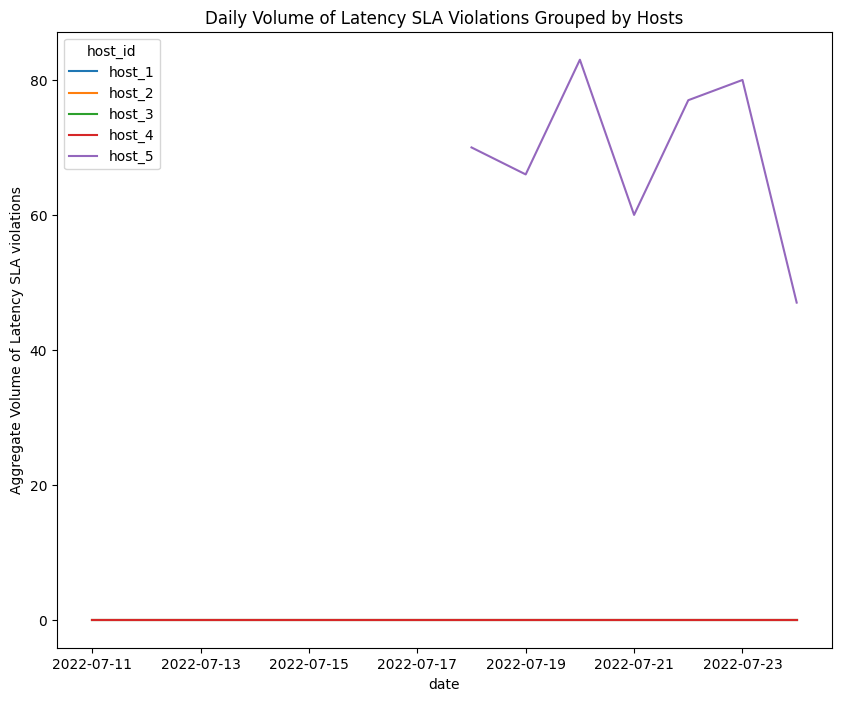

In [33]:
combined_groups['latency_ms'].apply(lambda x: (x >= 300 ).sum()).unstack('host_id').plot(figsize=(10, 8), title='Daily Volume of Latency SLA Violations Grouped by Hosts', ylabel='Aggregate Volume of Latency SLA violations')

#### To be Deleted

In [34]:
# combined_data_df

In [35]:
# training[0]

In [36]:
# request_sd = (combined_data_df[combined_data_df['date'] == combined_data_df['date'].iloc[0]]['request']).to_list()
# sorted(Counter(pd.Series([row['source'] for row in request_sd]).dropna()).items())
# [value[1] for value in sorted(Counter(pd.Series([row['source'] for row in request_sd]).dropna()).items())]

In [37]:
# sorted(Counter(pd.Series(news_sources_ref).replace('OTHER/UNKNOWN', None).dropna()).items())

In [38]:
# [value[1] for value in sorted(Counter(pd.Series(news_sources_ref).replace('OTHER/UNKNOWN', None).dropna()).items())]
# # == get_frequency(news_sources_ref, replace_before_dropping=True)

In [39]:
# get_frequency(news_sources_ref, replace_before_dropping=True)

In [40]:
# training_df = pd.DataFrame(training)
# training_df

In [41]:
# # ([4 * i / sum([1, 2, 3, 4])  for i in [1, 2, 3, 4]])
# l = [1, 2, 3, 4]
# np.array(l) / np.array(l).sum() * 4

## Step 4: Model inputs and outputs

In supervised machine learning settings, we assume that the training dataset D = {X, y} is composed of input/label tuples {Xi, yi} that are independently drawn from some underlying joint distribution ℙ(X, y) such that ℙ(X, y) = ℙ(y|X)ℙ(𝐗)

ℙ(y|X) is the relationship we are trying to learn during the model training step, which can then be used to generate accurate predictions for unseen samples. We make two assumptions here:
1. The unseen samples that the model will be used to make predictions on, comes from the same underlying distribution ℙ(X, y).
2. This distribution ℙ(X, y) is stationary and does not change with time.

In practice, as we saw in the lecture, this assumption does not hold in most cases. Can we track and quantify this change over time though?

### Step 4[part 1]: Input drift (hypothesis testing)

Hypothesis testing is a principled approach to evaluating drift. It’s a test to determine whether the difference between two populations (two sets of data) is statistically significant. If the difference is statistically significant, then the probability that the difference is a random fluctuation due to sampling variability is very low, and therefore, the difference is caused by the fact that these two populations come from two distinct distributions.

1. Design a test statistic (or a distance metric) that is computed on samples collected form the two distributions - in our case, the reference and target distributions (i.e. data points from the inference and reference datasets)
2. The test statistic is expected to be small if the null hypothesis is true (i.e. Z and Zref are drawn from the same distribution), and large if the alternative hypothesis (i.e. Z and Zref are drawn from different distributions) is true.
3. From the test statistic, we compute a p-value: When p-value ≤ threshold, results from the test are said to be statistically significant, and the null hypothesis P(z) = Pref(z) is rejected.


In [42]:
def get_field_from_requests(df, date_obj, field_name):
    news_requests = (df[df['date'] == date_obj]['request']).to_list()
    return [row[field_name] for row in news_requests]

<Axes: title={'center': 'A Measure of Statistical Significance of Daily Data Drift'}, xlabel='date', ylabel='p_values'>

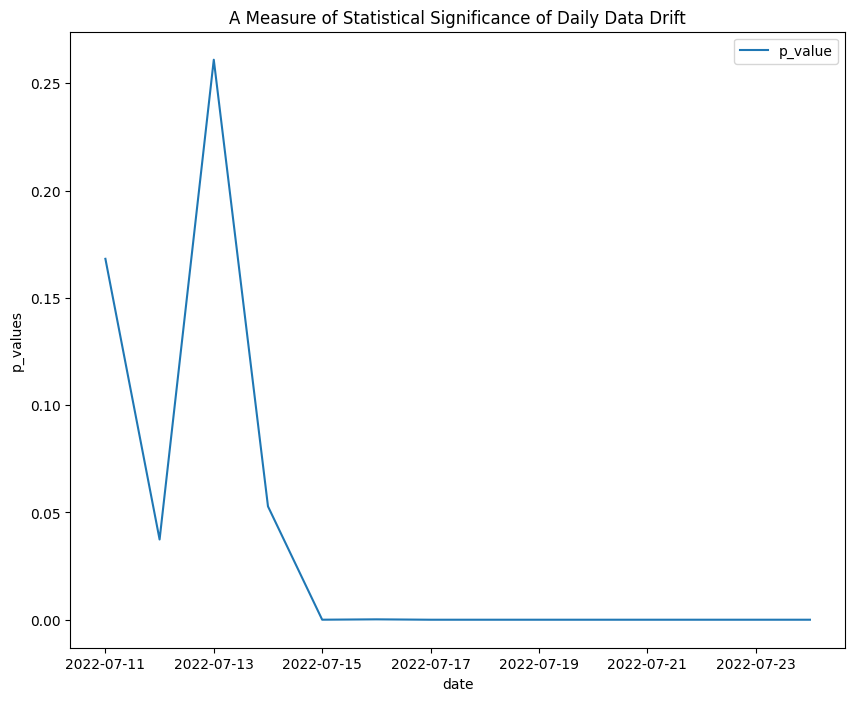

In [43]:
"""
[TO BE IMPLEMENTED]

News source (e.g. New York Times, Reuters, BBC etc) is an important piece of metadata about the incoming requests.
Different news sources cover different topics, and any shift in the distribution/prevalence of news sources
can be an important early signal to suggest that online traffic patterns might be changing.

1. Both, the training dataset and inference logs contains the news source metadata.
2. Using the training dataset as the reference, quantify the drift in news sources for incoming requests.
   You will compute drift for each day, using the inference logs from that day (i.e. "target") and comparing it to the training dataset (i.e. "reference")
3. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.

Which metric should you use to measure drift though? Chi-squared statistic is commonly used to measure drift for categorical features as we discussed.

Refer to:
1) https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
2) https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/chisquaredrift.html (in turn uses scipy under the hood)

These implementations will return the distance, and the p-value of the null hypothesis as part of the response
You want to plot the p-value in the line chart.

MAKE SURE YOU DEAL WITH MISSING/NULL/NONE VALUES IN THE TRAINING AND INFERENCE DATA IN A CONSISTENT WAY
"""
from scipy import stats
from collections import Counter, defaultdict

def get_sources_frequency(sources, replace_before_dropping=False, multiplier=0, return_sources=False):
    _sources = pd.Series(sources)
    # Ensure that None/Unknown is handled the same way across ref and target
    # Ref uses OTHER/UNKNOWN whilse Target uses None.
    # Replace missing sources in Ref (i.e. OTHER/UNKNOWN) with None before proceeding
    if replace_before_dropping:
        _sources = _sources.replace('OTHER/UNKNOWN', None)

    _sources = _sources.dropna()
    counter = Counter(_sources)
    counter_items = sorted(counter.items())
    frequency = np.array([value[1] for value in counter_items])

    # Scale the frequency; especially needed for the source since its frequency is more than the target.
    if multiplier > 0:
        frequency = frequency * multiplier / frequency.sum()
    if return_sources:
        sorted_sources = np.array([value[0] for value in counter_items])
        return frequency, sorted_sources
    else:
        return frequency

news_sources_ref = [row['source'] for row in training]

delta = LOG_DATE_END - LOG_DATE_START

news_sources_drift = []
news_sources_drift_map = defaultdict(list)


for d in range(delta.days + 1):
    curr_date = LOG_DATE_START + timedelta(days=d)
    # print(curr_date)

    # Step 1: collect all requests from logs.json with timestamp on the curr_date
    # this is currently a dummy empty list
    news_sources_target = get_field_from_requests(combined_data_df, curr_date, 'source')
    freq_observed = get_sources_frequency(news_sources_target)
    freq_expected = get_sources_frequency(news_sources_ref, replace_before_dropping=True, multiplier=sum(freq_observed))

    # Step 2: compute the drift between `news_sources_target` and `news_sources_ref` using Chi squared statistic
    # you can use either the scipy.stats.chisquare or the implementation in alibi-detect as shared in the references above
    _, p_value = stats.chisquare(f_obs=freq_observed, f_exp=freq_expected)

    # Step 3: store the pvalue in `news_sources_drift`
    news_sources_drift.append(p_value)
    news_sources_drift_map['date'].append(curr_date)
    news_sources_drift_map['p_value'].append(p_value)

# Step 4:  Plot the `news_sources_drift` as a line chart, with date on the X-axis and the computed metric on the Y-axis.
drift_df = pd.DataFrame(news_sources_drift_map)
drift_df.set_index('date', inplace=True)
drift_df.plot(figsize=(10, 8), ylabel='p_values', title='A Measure of Statistical Significance of Daily Data Drift')


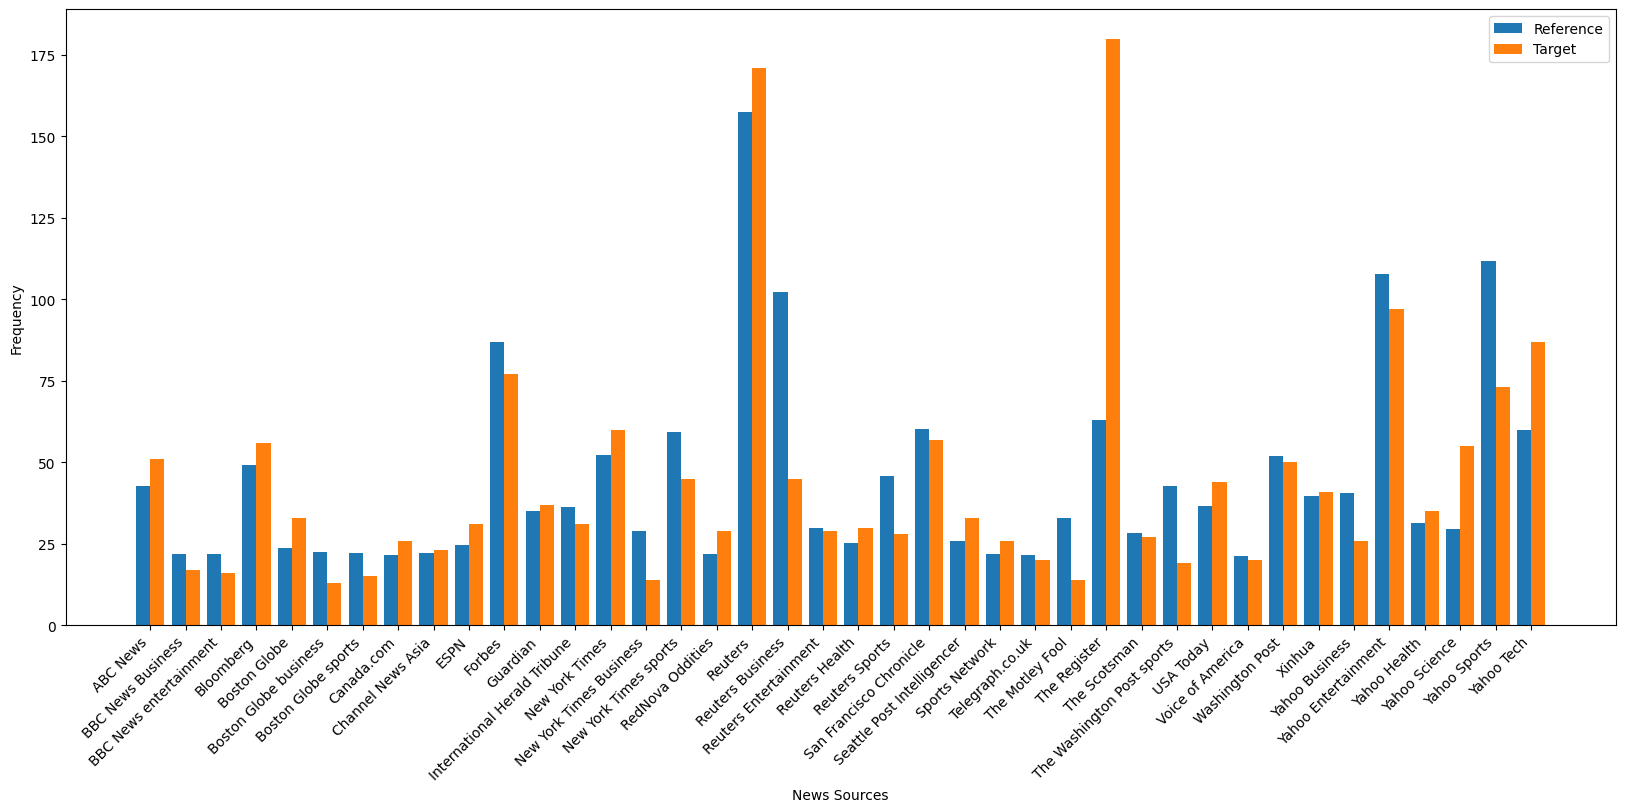

In [44]:
"""
[TO BE IMPLEMENTED]

It seems like there is some divergence in the distributions of the news sources feature between the reference and target set on some days.
Let's visualize this:

Let's take a look at the last day of inference traffic (you might observe p-value << 0.05 in the cell above for this day).
Plot a bar chart with the news sources on the X-axis, and normalized frequences in the reference and target datasets on the Y-axis

MAKE SURE TO NORMALIZE THE FREQUENCIES SINCE THE RAW NUMBER OF OBSERVATIONS IN BOTH LISTS WILL NOT BE THE SAME

"""

from typing import List


def plot_chart(news_sources: List, freq_reference: List, freq_target: List):
    X_axis = np.arange(len(news_sources))
    plt.figure(figsize=(20,8))
    plt.bar(X_axis - 0.2, freq_reference, 0.4, label='Reference')
    plt.bar(X_axis + 0.2, freq_target, 0.4, label='Target')

    plt.xticks(X_axis, news_sources, rotation=45, ha='right')
    plt.xlabel("News Sources")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

last_day_sources_target = get_field_from_requests(combined_data_df, LOG_DATE_END, 'source')
freq_target, news_sources = get_sources_frequency(last_day_sources_target, return_sources=True)
news_sources = news_sources.tolist()
freq_reference = get_sources_frequency(news_sources_ref, replace_before_dropping=True, multiplier=sum(freq_target))

# You can plot both the bar charts together by calling the `plot_chart` function
plot_chart(
    news_sources=news_sources,
    freq_reference=freq_reference,
    freq_target=freq_target,
)


### Step 4[part 2]: Input drift (Classifier based)

The previous approach of treating drift detection as a two-sample hypothesis test is based on designing the correct test statistic. Oftentimes it can be hard to choose the correct statistic, and most test statistics are prone to false positives especially for multivate high dimensional data.

What if we instead treat this as a classification problem? Can we train a classifier to predict which of the two distributions (reference or the target distribution) a given data point came from? The basic intuition is that if a classifier can learn to discriminate between the two distributions significantly better than random, then drift must have occurred.

The classifier-based drift detector tries to correctly distinguish instances from the reference dataset vs. the target dataset by training a classifier. It is possible to consume outputs of the classifier in a few different ways.

1. We can binarize the classifier prediction score based on a decision threshold, and apply a binomial test on the binarized predictions of the reference vs. the target data.
2. We can use the classifier prediction score directly and compare the different in score distributions for the reference and target datasets.



2022-07-11


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-12


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-13


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-14


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-15


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-16


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-17


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-18


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-19


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-20


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-21


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-22


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-23


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



2022-07-24


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/base.py:240: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



<Axes: title={'center': 'Classifier-based Approach to Measuring Statistical Significance of Daily Input Drift'}, xlabel='date', ylabel='p_values'>

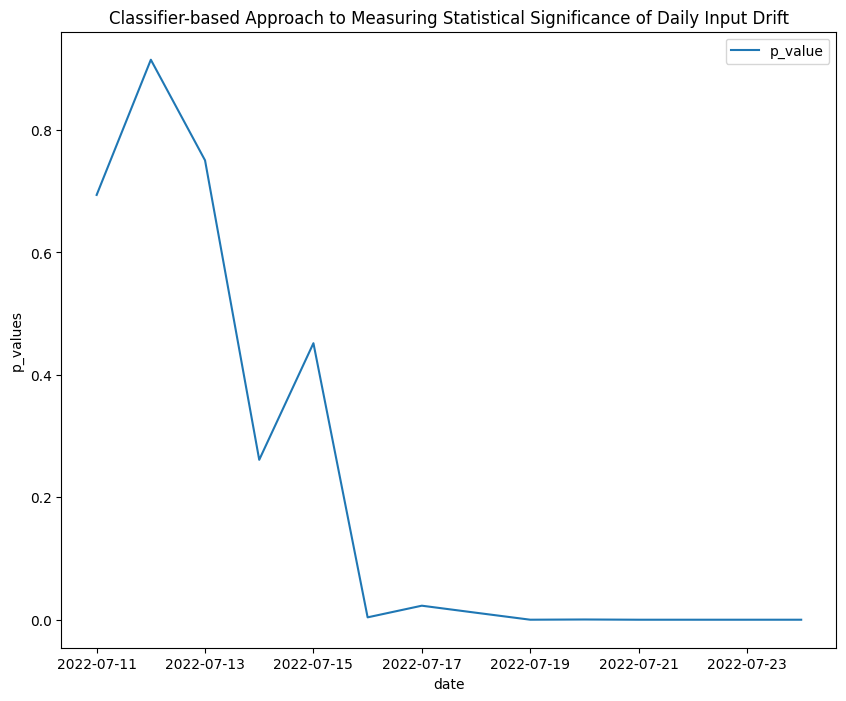

In [57]:
"""
[TO BE IMPLEMENTED]

Embeddings represent an encoding of the semantic content of the inputs to the model, and also the feature space on
top of which we train the classifier. Any shift in the space of embeddings can be an important signal to suggest
that online traffic patterns might be changing which can impact downstream model performance

1. Both, the training dataset and infernce logs contain embedding representations of the news article description.
2. Using the training dataset as the reference, quantify the drift in embeddings for incoming requests.
   You will compute drift for each day, using the inference logs from that day (i.e. "target") and comparing it to the training dataset (i.e. "reference")
3. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.

We will implement classifer-based drift detection for embeddings. You are free to choose the architecture of the classifier,
but feel free to go with something simple (e.g. logistic regression, or a neural network with one hidden layer).

Remember, this is a binary classifier that tries to predict whether a given data point belongs to the reference or the target distribution.

Also, remember that a new instance of the classifier will be trained for each (referce, target) pair i.e. for each day

Refer to:
1) https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/classifierdrift.html
2) https://openreview.net/forum?id=SJkXfE5xx

These implementations will return the distance, and the p-value of the null hypothesis as part of the response
You want to plot the p-value in the line chart.
"""

from sklearn.linear_model import LogisticRegression
from alibi_detect.cd import ClassifierDrift


embeddings_ref = [row['embedding'] for row in training]

delta = LOG_DATE_END - LOG_DATE_START
embeddings_drift = []
embeddings_drift_map = defaultdict(list)

for d in range(delta.days + 1):
    curr_date = LOG_DATE_START + timedelta(days=d)
    print(curr_date)

    # Step 1: collect all requests from logs.json with timestamp on the curr_date
    # this is currently a dummy empty list
    embeddings_target = get_field_from_requests(combined_data_df, curr_date, 'embedding')

    # Step 2: compute the drift between `embeddings_target` and `embeddings_ref`
    # (i) Initialize a new instance of the drift model (e.g. LogisticRegression())
    # (ii) Initialize the drift detector (check out https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/classifierdrift.html)
    # (iii) use the initialized drift detector to compute the p-value

    model = LogisticRegression()
    cd = ClassifierDrift(embeddings_ref, model, backend = 'sklearn', p_val=.05, preds_type='scores', verbose=0)
    drift_predictions = cd.predict(embeddings_target)

    # Step 3: store the pvalue in `embeddings_drift`
    p_val = drift_predictions["data"]["p_val"]
    embeddings_drift.append(p_val)
    embeddings_drift_map['date'].append(curr_date)
    embeddings_drift_map['p_value'].append(p_val)

# Step 4:  Plot the `embeddings_drift` as a line chart, with date on the X-axis and the computed metric on the Y-axis.
embeddings_drift_df = pd.DataFrame(embeddings_drift_map)
embeddings_drift_df.set_index('date', inplace=True)
embeddings_drift_df.plot(figsize=(10, 8), ylabel='p_values', title='Classifier-based Approach to Measuring Statistical Significance of Daily Input Drift')




In [46]:
"""
[TO BE IMPLEMENTED]

It seems like there is some divergence in the distributions of embeddings between the reference and target set on some days.
Let's visualize with UMAP (https://umap-learn.readthedocs.io/en/latest/). Uniform Manifold Approximation and Projection (UMAP)
is a dimension reduction technique that can be used for visualisation similarly to t-SNE.

1. We will train a UMAP model to project our original embedding space into 2 dimensions, using our reference (training) dataset.
2. We will then use this trained model to map the reference and the target dataset into two dimensions, and visualize it as a scatter plot.

Do this exercise separately for two target distributions:
1. inference traffic from 2022/07/11 (no drift)
2. inference traffic from 2022/07/24 (maximum drift)
"""

def train_umap_model(emb):
    umap_model = umap.UMAP(n_components=2)
    umap_model.fit(emb)
    return umap_model


umap_model = train_umap_model(embeddings_ref)
umap_ref = umap_model.transform(embeddings_ref)

# Similarly, use the umap_model.transform(...) function to compute 2d representations of inference traffic
umap_target_0711 = umap_model.transform(get_field_from_requests(combined_data_df, LOG_DATE_START, 'embedding'))
umap_target_0724 = umap_model.transform(get_field_from_requests(combined_data_df, LOG_DATE_END, 'embedding'))


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [47]:
import plotly.express as px

final_df = []
for idx, ut in enumerate(umap_ref[:5000]):
    final_df.append([ut[0], ut[1], 'reference'])

for idx, ut in enumerate(umap_target_0711):
    final_df.append([ut[0], ut[1], 'target_2022-07-11'])

df = pd.DataFrame(
    final_df, columns=["x", "y", "label"]
)

fig = px.scatter(df, x="x", y="y", color="label", width=1100, height=600)
fig.update_traces(marker={'size': 3})
fig.show()


In [48]:
import plotly.express as px

final_df = []
for idx, ut in enumerate(umap_ref[:5000]):
    final_df.append([ut[0], ut[1], 'reference'])

for idx, ut in enumerate(umap_target_0724):
    final_df.append([ut[0], ut[1], 'target_2022-07-24'])

df = pd.DataFrame(
    final_df, columns=["x", "y", "label"]
)

fig = px.scatter(df, x="x", y="y", color="label", width=1100, height=600)
fig.update_traces(marker={'size': 3})
fig.show()


## Step 5: Model performance

Ground truth observations (true labels) are a critical part of all supervised/self-supervised machine learning. Ground truth is important not just for model training, but also for monitoring and measuring performance of models after deployment.

`annotations.json` is the set of ground truth labels for requests received by our online prediction service. Imagine we have a team of human annotators that label a fraction of our inference stream (with some delay). Eventually these ground truth labels are logged and will be helpful for us to monitor online model performance.


In [49]:
"""
[TO BE IMPLEMENTED]

Weekly classification report

Compute the a classification report for each week of the logged inference data
   Week 1 = [2022-07-11 and 2022-07-17]
   Week 2 = [2022-07-18 and 2022-07-24]

Do you notice a trend in model performance?
How does this correlate to observed drift in news source, embeddings etc ?
"""

from sklearn import metrics as sklearn_metrics

w1_start, w1_end = date(2022, 7, 11), date(2022, 7, 17)
w2_start, w2_end = date(2022, 7, 18), date(2022, 7, 24)

# Convert log file data to Dataframe
logs_df = pd.DataFrame(logs)
logs_df.set_index('id', inplace=True)
logs_df['date'] = pd.to_datetime(logs_df['timestamp']).dt.date

# extract rows for first and second weeks
logs_w1_df = logs_df[(logs_df['date'] >= w1_start) & (logs_df['date'] <= w1_end)]
logs_w2_df = logs_df[(logs_df['date'] >= w2_start) & (logs_df['date'] <= w2_end)]

# extract predicted labels for each week
pred_label_w1 = logs_w1_df['pred_label'].tolist()
pred_label_w2  = logs_w2_df['pred_label'].tolist()

# extract true labels for each week
true_label_w1 = logs_w1_df['label'].tolist()
true_label_w2 = logs_w2_df['label'].tolist()

print("Dates: 2022/07/11 to 2022/07/17")
print(sklearn_metrics.classification_report(true_label_w1, pred_label_w1))

print("Dates: 2022/07/18 to 2022/07/24")
print(sklearn_metrics.classification_report(true_label_w2, pred_label_w2))


Dates: 2022/07/11 to 2022/07/17
                           precision    recall  f1-score   support

                 Business       0.67      0.85      0.75      8138
            Entertainment       0.69      0.52      0.60     12914
                   Health       0.64      0.71      0.67      3171
              Music Feeds       0.98      0.78      0.87       204
                 Sci/Tech       0.65      0.63      0.64      7159
Software and Developement       0.52      0.05      0.09       655
                   Sports       0.80      0.92      0.86      9437
                    Toons       1.00      1.00      1.00       322

                 accuracy                           0.71     42000
                macro avg       0.74      0.68      0.68     42000
             weighted avg       0.70      0.71      0.69     42000

Dates: 2022/07/18 to 2022/07/24
                           precision    recall  f1-score   support

                 Business       0.37      0.85      0.51     

<Axes: title={'center': 'Daily Accuracy Scores'}, xlabel='date', ylabel='accuracies'>

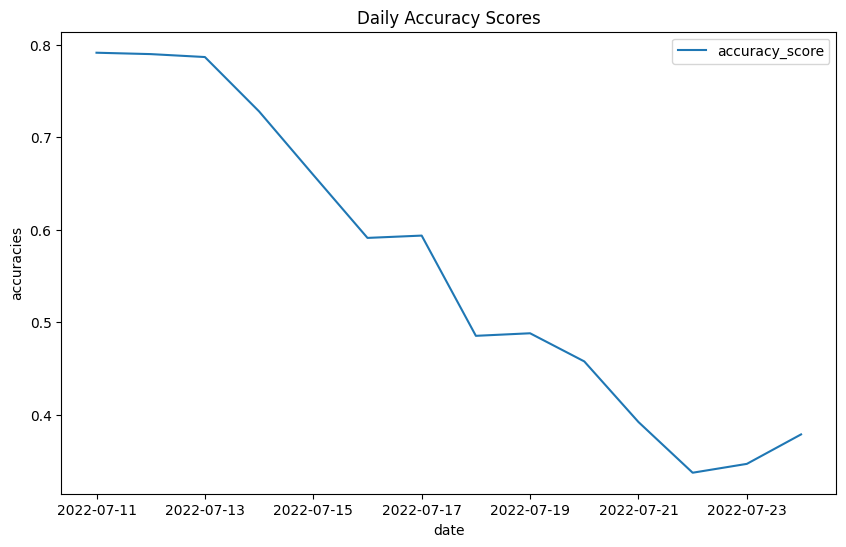

In [50]:

"""
[TO BE IMPLEMENTED]

Daily aggregate classification accuracy

1. Compute the daily aggregate classification accuracy of the model
2. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.

Do you notice a trend in model performance?
How does this correlate to observed drift in news source, embeddings etc ?
"""
# sklearn_metrics
logs_groups_by_date = logs_df[['date', 'pred_label', 'label']].groupby('date')
daily_accuracies = defaultdict(list)

for key, item in logs_groups_by_date:
    daily_accuracies['date'].append(key)
    daily_accuracies['accuracy_score'].append(sklearn_metrics.accuracy_score(item['label'].tolist(), item['pred_label'].tolist()))

daily_accuracies_df = pd.DataFrame(daily_accuracies)
daily_accuracies_df.set_index('date', inplace=True)
# display(daily_accuracies_df)

daily_accuracies_df.plot(figsize=(10, 6), ylabel='accuracies', title='Daily Accuracy Scores')

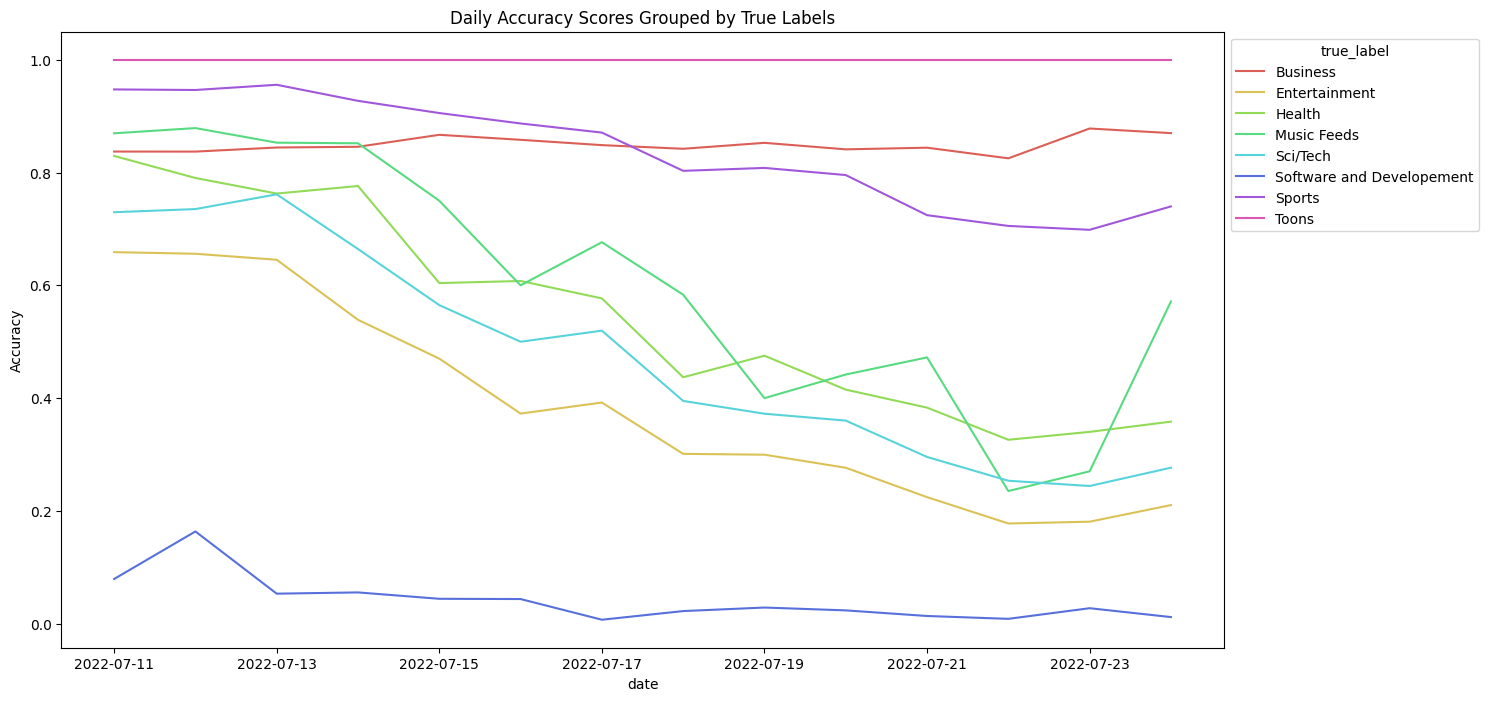

In [51]:
"""
[TO BE IMPLEMENTED]

Daily classification accuracy, grouped by label

1. Compute the daily classification accuracy of the model, grouped by the true label category
2. Plot each of these as a line chart, with date on the X-axis and the computed metric on the Y-axis.
   You can plot them on the same chart, with different colors for each label

Do you notice a trend in model performance?
Are there labels that degrade more quickly or less quickly?
Are there labels that consistently perform worse?
"""

logs_groups_by_date_and_labels = logs_df[['date', 'pred_label', 'label']].groupby(['date', 'label'])
daily_accuracies_by_labels = defaultdict(list)

for key, item in logs_groups_by_date_and_labels:
    daily_accuracies_by_labels['date'].append(key[0])
    daily_accuracies_by_labels['true_label'].append(key[1])
    daily_accuracies_by_labels['accuracy_score'].append(sklearn_metrics.accuracy_score(item['label'].tolist(), item['pred_label'].tolist()))

daily_accuracies_by_labels_df = pd.DataFrame(daily_accuracies_by_labels)

# daily_accuracies_by_labels_df.plot(figsize=(10, 6), x='date', y=['true_label', 'accuracy_score'], title='Daily Accuracy Scores Grouped by True Label')
# daily_accuracies_by_labels_df.plot(x="date", y=["true_label", "accuracy_score"], kind="line", figsize=(10, 10))
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(
    ax=ax,
    data = daily_accuracies_by_labels_df,
    x = 'date',
    y = 'accuracy_score',
    hue = 'true_label',
    palette = 'hls').set(title='Daily Accuracy Scores Grouped by True Labels', ylabel='Accuracy', xlabel='date')#, rc={'figure.figsize':(11.7,8.27)})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## [Optional] Step 6: Outliers & its impact on model performance

A common cause for ML model failures is outliers - data samples that are very different or “unlike” the rest of the samples, and hence unlikely to be seen by the model during training. Doing well on such outliers is especially critical for high stakes applications like self-driving cars and medical diagnostics

Unfortunately, it's not very easy to detect outliers because it's hard to constitute the criteria for an outlier. Typically, outlier detection algorithms fit (ex. via reconstruction) to the training set to understand what normal data looks like and then we can use a threshold to predict outliers.

Libraries such as [PyOD](https://pyod.readthedocs.io/en/latest/) and [Alibi Detect](https://docs.seldon.io/projects/alibi-detect/en/latest/) are popular open source libraries for outlier detection.


In [52]:
"""
[TO BE IMPLEMENTED]

Consider using libraries shared above to identify the most outlier examples
from the inference traffic, with respect to the training dataset.

Some approaches/architectures you might consider:
1. Local Outlier Factor or Isolation Forest (https://scikit-learn.org/stable/modules/outlier_detection.html)
2. Variational Auto encoder (https://github.com/yzhao062/pyod)
"""
from sklearn.ensemble import IsolationForest

X = [item['embedding'] for item in training]
test_X = [item['request']['embedding'] for item in logs]

clf = IsolationForest(n_estimators=10, warm_start=True)

clf.fit(X)

outliers_pred = clf.predict(test_X)
outliers_pred

array([ 1, -1,  1, ...,  1,  1,  1])

,date,pred_label,label,outliers
id,,,,
444122,2022-07-11,Health,Health,-1
357877,2022-07-11,Sports,Sports,-1
214598,2022-07-11,Sports,Sports,-1
166161,2022-07-11,Sports,Sports,-1
365775,2022-07-11,Sports,Sports,-1
...,...,...,...,...
id_263684,2022-07-24,Business,Entertainment,-1
id_141595,2022-07-24,Business,Entertainment,-1
id_141127,2022-07-24,Sci/Tech,Entertainment,-1


<Axes: title={'center': 'Daily Accuracy Scores for Outlier Data Points'}, xlabel='date', ylabel='accuracies'>

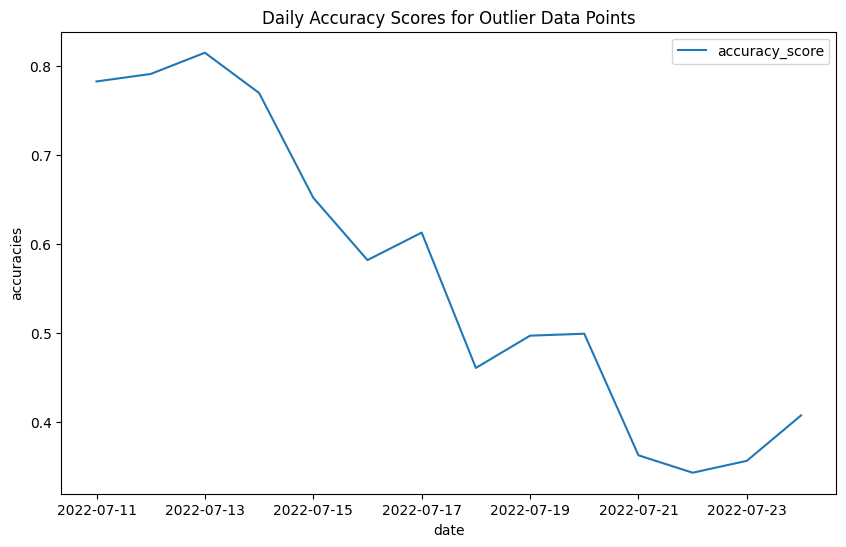

In [53]:
"""
[TO BE IMPLEMENTED]

Measure the model performance (model accuracy) on the subset of data that is identified as outliers.

1. Compute the daily aggregate classification accuracy of the model on the subset of data that is identified as outliers.
2. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.

How does the model's performance on outliers compare to that on the inliers?
Do you see model performance is lower for outliers?
"""
_logs_df = logs_df.copy()

# Add outlier predictions to the logs dataframe
_logs_df['outliers'] = outliers_pred

# Extract outliers from the logs dataframe. Outliers have prediction value of -1
outliers_df = _logs_df[_logs_df['outliers'] == -1][['date', 'pred_label', 'label', 'outliers']]
display(outliers_df)

# group outliers by date
outliers_group_by_date = outliers_df.groupby('date')
outliers_daily_accuracies = defaultdict(list)

# calulate the accuracy score of the predicted outlier data points
for key, item in outliers_group_by_date:
    outliers_daily_accuracies['date'].append(key)
    outliers_daily_accuracies['accuracy_score'].append(sklearn_metrics.accuracy_score(item['label'].tolist(), item['pred_label'].tolist()))

outliers_daily_accuracies_df = pd.DataFrame(outliers_daily_accuracies)
outliers_daily_accuracies_df.set_index('date', inplace=True)

outliers_daily_accuracies_df.plot(figsize=(10, 6), ylabel='accuracies', title='Daily Accuracy Scores for Outlier Data Points')